Import all the library we need for transfer learning

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models

In [27]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [28]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../dataImage/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1125 files belonging to 15 classes.


In [29]:
class_name = dataset.class_names
class_name

['Acer',
 'Alnus incana',
 'Betula pubescens',
 'Fagus silvatica',
 'Populus',
 'Populus tremula',
 'Quercus',
 "Salix alba 'Sericea'",
 'Salix aurita',
 'Salix sinerea',
 'Sorbus aucuparia',
 'Sorbus intermedia',
 'Tilia',
 'Ulmus carpinifolia',
 'Ulmus glabra']

Print out some images from the batch to see whether the loaded images are correct.

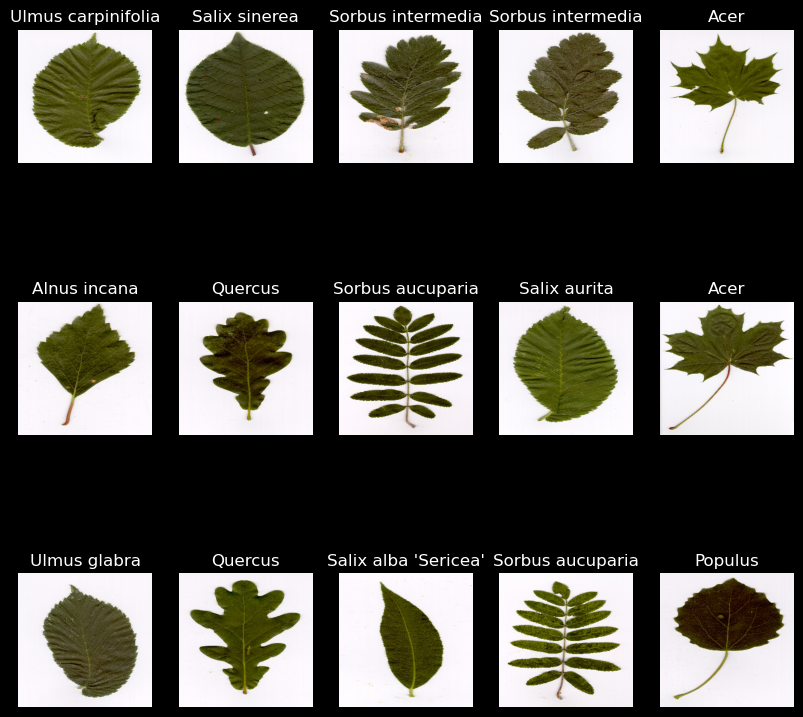

In [30]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

Divide the validation dataset into two parts. One part goes to validation dataset and the other goes to test dataset

In [31]:
train_ds = dataset.take(25)
val_ds = dataset.skip(25).take(6)
test_ds = dataset.skip(25).skip(6)
print(f"the size of train_ds {len(train_ds)} \nthe size of val_ds {len(val_ds)} \nthe size of test_ds {len(test_ds)}")

the size of train_ds 25 
the size of val_ds 6 
the size of test_ds 5


In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [33]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.3)
])

Print out what images are like after augmentation

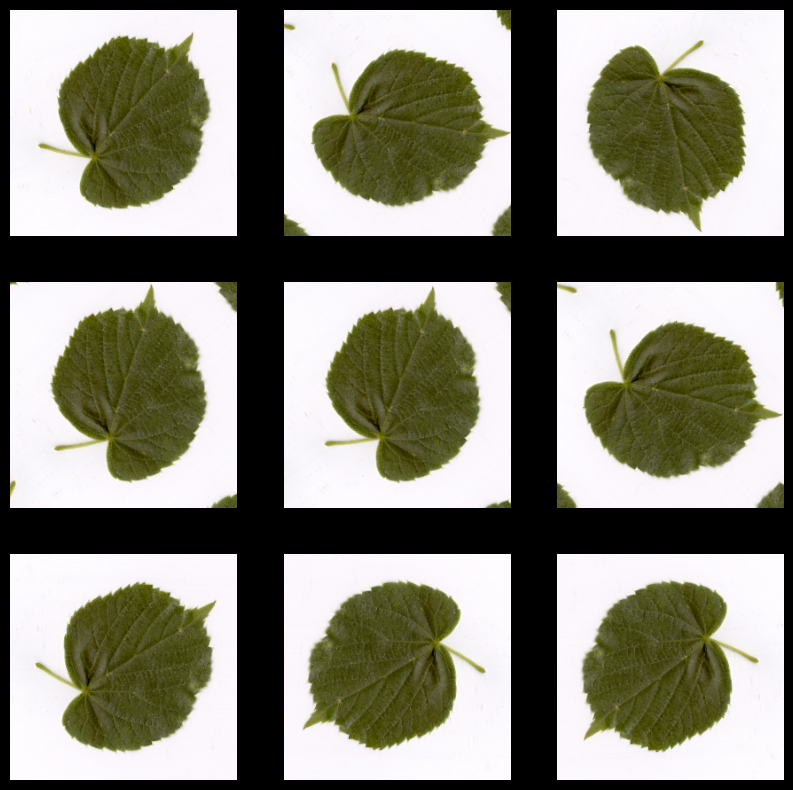

In [35]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [36]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Create the base model from the pre-trained model VGG19

In [37]:

IMAGE_SIZE = (256, 256)
IMG_SHAPE =IMAGE_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="imagenet")

In [38]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 512)


In [39]:
base_model.trainable = False

Let's take a look at the base model architecture

In [40]:

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

Train models with train dataset

In [41]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])
model.build(input_shape= (32, 256, 256, 3))

In [42]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

The summary of the model

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                2097216   
                                                                 
 dense_4 (Dense)             (None, 15)                975       
                                                                 
Total params: 22,122,575
Trainable params: 2,098,191
N

In [44]:
len(model.trainable_variables)

4

Test the accuracy of the model with validation dataset

In [45]:
history = model.fit(
    train_ds,
    epochs = 10,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/10


25/25 [==============================] - 104s 4s/step - loss: 2.9385 - accuracy: 0.2663 - val_loss: 1.7671 - val_accuracy: 0.4688
Epoch 2/10
25/25 [==============================] - 102s 4s/step - loss: 1.3928 - accuracy: 0.5950 - val_loss: 1.0928 - val_accuracy: 0.6979
Epoch 3/10
25/25 [==============================] - 103s 4s/step - loss: 0.8604 - accuracy: 0.7925 - val_loss: 0.6247 - val_accuracy: 0.8802
Epoch 4/10
25/25 [==============================] - 102s 4s/step - loss: 0.5318 - accuracy: 0.9050 - val_loss: 0.4351 - val_accuracy: 0.9115
Epoch 5/10
25/25 [==============================] - 103s 4s/step - loss: 0.3830 - accuracy: 0.9275 - val_loss: 0.3287 - val_accuracy: 0.9323
Epoch 6/10
25/25 [==============================] - 103s 4s/step - loss: 0.2720 - accuracy: 0.9538 - val_loss: 0.2937 - val_accuracy: 0.9219
Epoch 7/10
25/25 [==============================] - 103s 4s/step - loss: 0.2493 - accuracy: 0.9400 - val_loss: 0.2354 - val_accuracy: 0.9531
Epoch 8/10
25/25 [======

Print out the accuracy of the model and its learning curve.

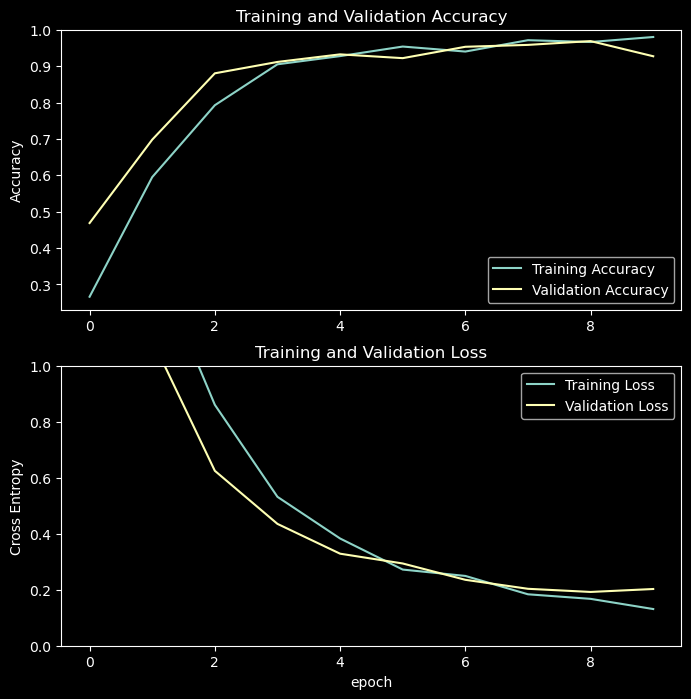

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 169ms/step


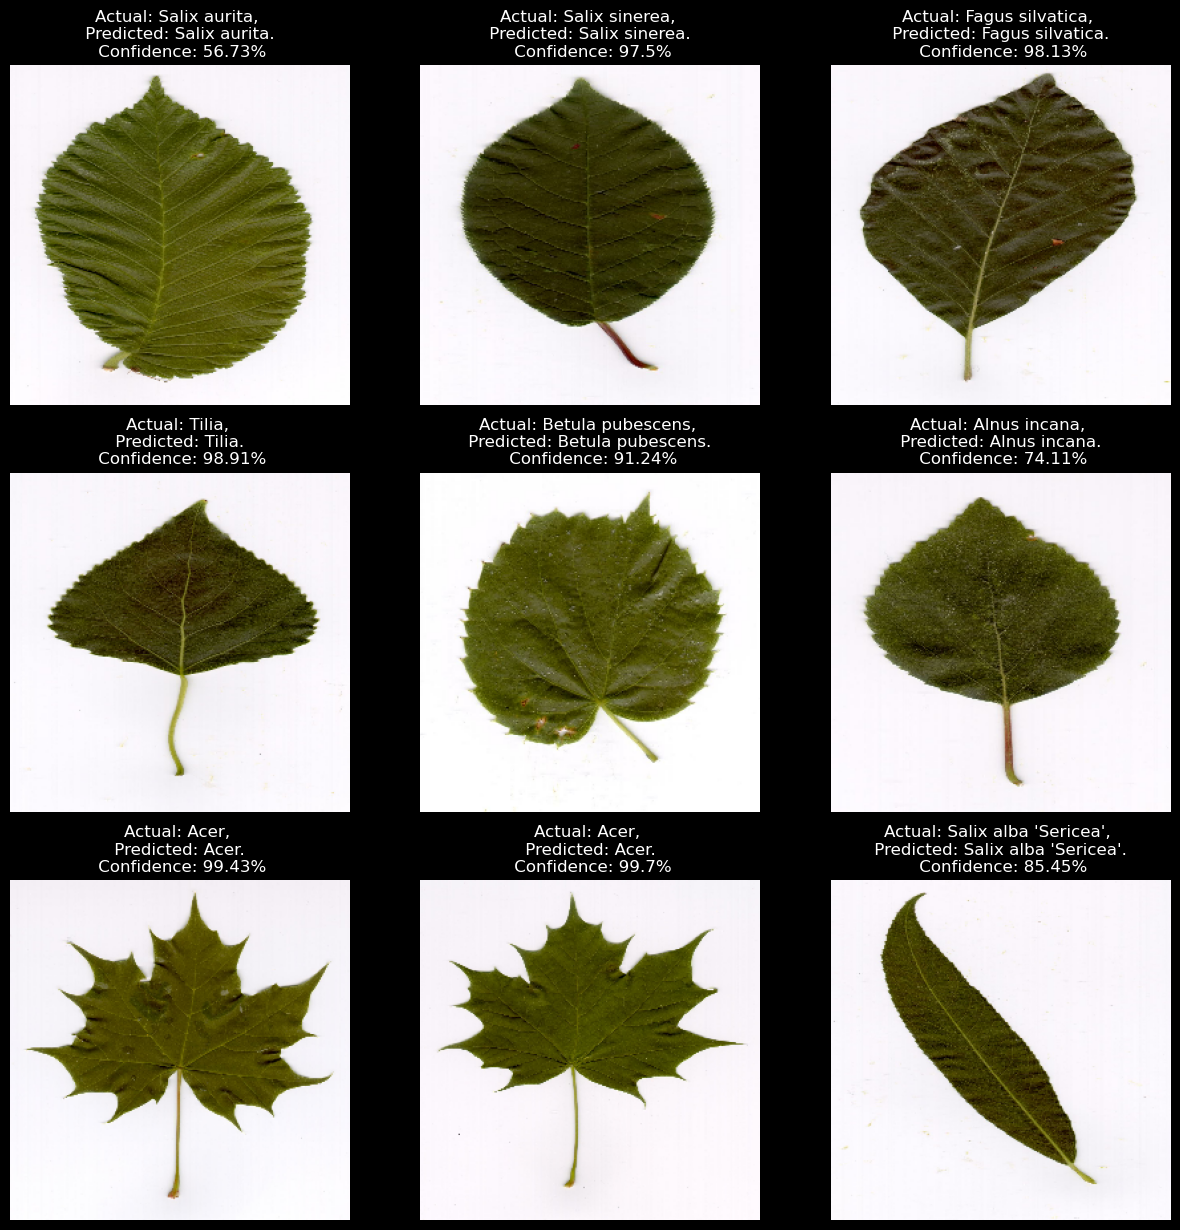

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")